![](img/330-banner.png)

# Lecture 9: Regression Evaluation Metrics

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Learning outcomes 

From this lecture, students are expected to be able to:

- Apply scikit-learn regression model (e.g., Ridge) to regression problems.
- Relate the Ridge hyperparameter `alpha` to the `LogisticRegression` hyperparameter `C` (they are opposites)
- Appropriately select a scoring metric given a regression problem.
- Interpret and communicate the meanings of different scoring metrics on regression problems.
    - MSE, RMSE, $R^2$, MAPE
- (optional) Apply log-transform on the target values in a regression problem with `TransformedTargetRegressor`.

## 1. Data set

In this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/). As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data`. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [3]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size = 0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- Here, the target is `SalePrice`. Note that this is numeric, not categorical.
- In this case, we call the task **regression** (as opposed to classification).

In [4]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [5]:
X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']

X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

### EDA

In [6]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1314.000000,1314.000000,1089.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1307.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,734.182648,56.472603,69.641873,10273.261035,6.076104,5.570015,1970.995434,1984.659056,102.514155,441.425419,...,94.281583,45.765601,21.726788,3.624049,13.987062,3.065449,46.951294,6.302131,2007.840183,179802.147641
std,422.224662,42.036646,23.031794,8997.895541,1.392612,1.112848,30.198127,20.639754,178.301563,459.276687,...,125.436492,65.757545,60.766423,30.320430,53.854129,42.341109,522.283421,2.698206,1.332824,79041.260572
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,369.250000,20.000000,59.000000,7500.000000,5.000000,5.000000,1953.000000,1966.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129600.000000
50%,735.500000,50.000000,69.000000,9391.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,376.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000
75%,1099.750000,70.000000,80.000000,11509.000000,7.000000,6.000000,2000.000000,2004.000000,165.500000,704.750000,...,168.000000,66.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,212975.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 302 to 1389
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1314 non-null   int64  
 1   MSSubClass     1314 non-null   int64  
 2   MSZoning       1314 non-null   object 
 3   LotFrontage    1089 non-null   float64
 4   LotArea        1314 non-null   int64  
 5   Street         1314 non-null   object 
 6   Alley          81 non-null     object 
 7   LotShape       1314 non-null   object 
 8   LandContour    1314 non-null   object 
 9   Utilities      1314 non-null   object 
 10  LotConfig      1314 non-null   object 
 11  LandSlope      1314 non-null   object 
 12  Neighborhood   1314 non-null   object 
 13  Condition1     1314 non-null   object 
 14  Condition2     1314 non-null   object 
 15  BldgType       1314 non-null   object 
 16  HouseStyle     1314 non-null   object 
 17  OverallQual    1314 non-null   int64  
 18  Overal

### `pandas_profiler`

In [8]:
from pandas_profiling import ProfileReport

# profile = ProfileReport(train_df, title='Pandas Profiling Report') #, minimal=True)
# profile.to_notebook_iframe()

### Feature types 

- Do not blindly trust all the info given to you by automated tools. 
- How does pandas profiling figure out the data type?
    - You can look at the Python data type and say floats are numeric, strings are categorical.
    - However, in doing so you would miss out on various subtleties such as some of the string features being ordinal rather than truly categorical.
    - Also, it will think free text is categorical.
- In addition to tools such as above, it's important to go through data description to understand the data.
- The data description for our dataset is available [here](https://www.kaggle.com/c/home-data-for-ml-course/data?select=data_description.txt).     

### Feature types 

- We have mixed feature types and a bunch of missing values. 
- Now, let's do some of the dirty work. 

- Let's get the numeric columns. 

In [9]:
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
print(numeric_looking_columns)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [10]:
train_df['BedroomAbvGr'].unique()

array([3, 4, 2, 1, 5, 0, 6, 8])

In [11]:
train_df['KitchenAbvGr'].unique()

array([1, 2, 3])

In [12]:
train_df['MSSubClass'].unique()

array([ 20,  50,  30,  60, 160,  85,  90, 120, 180,  80,  70,  75, 190,
        45,  40])

In [13]:
train_df['MoSold'].unique()

array([ 1,  7,  3,  5,  8, 10,  6,  9, 12,  2,  4, 11])

In [14]:
drop_features    = ['Id']
numeric_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 
                    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                    'PoolArea', 'MiscVal', 'YrSold']

In [15]:
set(numeric_looking_columns) - set(numeric_features)

{'BedroomAbvGr', 'Id', 'KitchenAbvGr', 'MSSubClass', 'MoSold'}

We'll treat the above numeric-looking features as categorical features. 

- There are a bunch of ordinal features using the same scale: excellent, good, average, etc.
  - These we'll be calling `ordinal_features_reg`.

In [16]:
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] # if N/A it will just impute something, per below
[ordering]*len(ordinal_features_reg)

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

We'll pass the above as categories in our `OrdinalEncoder`. 

- There are a bunch more ordinal features using different scales.
  - These we'll be calling `ordinal_features_oth`
  - To save time we'll ignore the ordinality and just encoding them as categorical.
  - In real-life situation, you would go through each feature from `ordinal_features_oth` and encode it separately. 

In [17]:
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']

The remaining features are categorical features.

In [18]:
categorical_features = list(set(X_train.columns) - set(numeric_features) 
                            - set(ordinal_features_reg) - set(drop_features))


- We are not doing it here but we can engineer our own features too. 
- Would price per square foot be a good feature to add in here?

### Video 2

Note that in the previous video I missed excluding the following from the numeric columns. They are actually categorical columns. 
- 'BedroomAbvGr', 
- 'KitchenAbvGr', 
- 'MSSubClass', 
- 'MoSold'


## 2. Applying feature transformations

- Since we have mixed feature types, let's use `ColumnTransformer` to apply different transformations on different features types.  
- Similar to `make_pipeline`, there is [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [19]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy='median'), 
                                    StandardScaler())
ordinal_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                    OrdinalEncoder(categories=[ordering]
                                                   *len(ordinal_features_reg)))
categorical_transformer = make_pipeline(SimpleImputer(strategy='constant', fill_value="missing"),
                                        OneHotEncoder(handle_unknown='ignore', sparse=False))

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features_reg),
    (categorical_transformer, categorical_features)    
)

### Other possible preprocessing?  

- There is a lot of room for improvement ...
- We're just using `SimpleImputer`.
    - In reality we'd want to go through this more carefully.
    - We may also want to drop some columns that are almost entirely missing.    
    - (More on this in 562.)
- We could also check for outliers, and do other exploratory data analysis (EDA).
- We should deal with `ordinal_features_oth` properly. 
- But for now this is good enough ...    

### Let's look at what all columns have we created

In [20]:
preprocessor.fit(X_train); # Calling fit to examine all the transformers. 
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [21]:
ohe_columns = list(preprocessor.named_transformers_['pipeline-3'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [22]:
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageFinish_Unf,GarageFinish_missing,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
302,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,-0.287191,2.197106,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
767,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,-0.287191,-0.553138,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
429,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,-0.287191,-0.408626,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,-0.287191,-0.672812,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
558,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,-0.287191,-1.000222,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
X_train.shape

(1314, 80)

In [24]:
X_train_enc.shape

(1314, 297)

We went from 80 features to 297 features!! 

## 3. Model building 

### `DummyRegressor`

In [25]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.001665,0.000322,-0.000356,0.0
1,0.000920,0.000277,-0.013209,0.0
2,0.000839,0.000241,-0.011104,0.0
3,0.000786,0.000233,-0.000994,0.0
4,0.000843,0.000236,-0.000872,0.0


### `Ridge`

- Linear regression is one of the most basic and popular ML/statistical techniques. (DSCI 561, DSCI 562)
- We already saw logistic regression for classification - these are close cousins.
- Both are very interpretable.
- In `scikit-learn`, we can use `LinearRegression()`
- However, in this course, I am going to recommend using `Ridge()` instead because it is more flexible than `LinearRegression`.
    - It has a hyperparameter `alpha` which controls the fundamental tradeoff. 

### Problem with using `LinearRegression`

In [26]:
lr_vanilla = make_pipeline(preprocessor, LinearRegression())
lr_vanilla.fit(X_train, y_train);
lr_vanilla_preds = lr_vanilla.predict(X_test)
lr_vanilla_preds[:10]

array([ 2.23342000e+05,  7.43450000e+04,  1.41895000e+05,  2.58318000e+05,
        1.36461000e+05,  2.42045000e+05,  3.26600000e+05, -1.61112414e+13,
        1.37215000e+05,  1.33151000e+05])

In [27]:
y_train.max(), y_train.min()

(755000, 34900)

In [28]:
lr_vanilla_preds.max(), lr_vanilla_preds.min()

(1325000567001302.0, -33904943622928.5)

In [29]:
print("Smallest coefficient: ", lr_vanilla.named_steps['linearregression'].coef_.min()) 
print("Largest coefficient:", lr_vanilla.named_steps['linearregression'].coef_.max())

Smallest coefficient:  -1.4500829623644742e+16
Largest coefficient: 1.7616706830460834e+16


- The coefficients get huge. 
- This happened because we have "collinear features". 

Ridge "solves" this issue:


In [30]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

In [31]:
lr_preds = lr.predict(X_test)
lr_preds[:10]

array([221549.8053651 ,  81971.10463701, 137312.73470391, 248188.15317509,
       130242.14463214, 202224.70108074, 333861.36971875, 119370.04712692,
       144277.46832442, 124823.63577347])

In [32]:
lr_preds.max(), lr_preds.min()

(419182.24259150994, 36116.22480668704)

In [33]:
print("Smallest coefficient: ", lr.named_steps['ridge'].coef_.min()) 
print("Largest coefficient:", lr.named_steps['ridge'].coef_.max())

Smallest coefficient:  -188956.2188104909
Largest coefficient: 80029.764867831


- So instead of using `LinearRegression`, always use something else, such as `Ridge`.

In [34]:
pd.DataFrame(cross_validate(lr, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.050134,0.010955,0.858760,0.914892
1,0.043764,0.010673,0.809775,0.917294
2,0.041412,0.010529,0.777188,0.918846
3,0.044447,0.010504,0.878668,0.913569
4,0.042144,0.011234,0.842014,0.915241
5,0.041663,0.010110,0.818248,0.913873
6,0.045845,0.010699,0.823908,0.917189
7,0.042934,0.010489,0.872585,0.913342
8,0.042287,0.009754,0.145659,0.925504
9,0.043095,0.011235,0.889766,0.911513


- Quite a bit of variation in the test scores. 
- Performing poorly in fold 8. Not sure why. 

### `alpha` hyperparameter of `Ridge`
- Ridge has a hyperparameter `alpha` that controls the fundamental tradeoff.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the inverse of `C`.
- That is, large `C` is like small `alpha` and vice versa.
- Smaller `alpha`: lower training error (overfitting)

In [35]:
import scipy
nums = scipy.stats.randint(low=0.00001, high=100000)


In [36]:
alphas = 10.0**np.arange(-5,5,1)
train_scores = []
cv_scores = []
for alpha in alphas:
    lr = make_pipeline(preprocessor, Ridge(alpha=alpha))
    results = cross_validate(lr, X_train, y_train, return_train_score=True)
    train_scores.append(np.mean(results["train_score"]))
    cv_scores.append(np.mean(results["test_score"]))

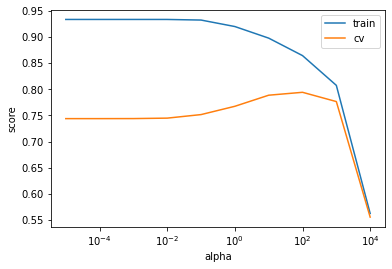

In [37]:
plt.semilogx(alphas, train_scores, label="train");
plt.semilogx(alphas, cv_scores, label="cv");
plt.legend();
plt.xlabel('alpha');
plt.ylabel('score');

In [38]:
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

100.0

- It seems alpha=100 is the best choice here.

### `RidgeCV`

BTW, because it's so common to want to tune `alpha` with `Ridge`, sklearn provides a class called `RidgeCV`, which automatically tunes `alpha` based on cross-validation.

In [39]:
ridgecv = make_pipeline(preprocessor, RidgeCV(alphas=alphas))
ridgecv.fit(X_train, y_train);
ridgecv[1].alpha_

100.0

- General intuition: larger `alpha` leads to smaller coefficients.
- Smaller coefficients mean the predictions are less sensitive to changes in the data.
- Hence less chance of overfitting (seeing big dependencies when you shouldn't).
- We'll learn more about this later in this course. 

## 4. Regression score functions

- We aren't doing classification anymore, so we can't just check for equality:

In [40]:
lr_tuned = make_pipeline(preprocessor, Ridge(alpha=best_alpha))
lr_tuned.fit(X_train, y_train);

In [41]:
lr_tuned.predict(X_train) == y_train

302     False
767     False
429     False
1139    False
558     False
        ...  
1041    False
1122    False
1346    False
1406    False
1389    False
Name: SalePrice, Length: 1314, dtype: bool

In [42]:
y_train.values

array([205000, 160000, 175000, ..., 262500, 133000, 131000])

In [43]:
lr_tuned.predict(X_train)

array([216373.2414166 , 187048.00984703, 189052.76493509, ...,
       239184.11742462, 134178.40793057, 131249.02308952])

We need a score that reflects how right/wrong each prediction is.

A number of popular scoring functions for regression. We are going to look at some common metrics: 

- mean squared error (MSE)
- $R^2$
- root mean squared error (RMSE)
- MAPE

See [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) for more details. 

### Mean squared error (MSE)

- A common measure is mean squared error:

In [44]:
preds = lr_tuned.predict(X_train)

In [45]:
np.mean((y_train - preds)**2)

865443401.1072437

Perfect predictions would have MSE=0.

In [46]:
np.mean((y_train - y_train)**2)

0.0

This is also implemented in sklearn:

In [47]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(y_train, preds)

865443401.1072437

- MSE looks huge and unreasonable. There is an error of ~\$1 Billion!
- Is this score good or bad?
- Unlike classification, with regression our target has units. 
- The target is in dollars, the mean squared error is in $dollars^2$ 
- The score also depends on the scale of the targets. 
- If we were working in cents instead of dollars, our MSE would be $10,000 \times (100^2$) higher!

In [48]:
np.mean((y_train*100 - preds*100)**2)

8654434011072.438

### $R^2$ (not in detail)

A common score is the $R^2$

- This is the score that `sklearn` uses by default when you call score():
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: mean squared error, but flipped (higher is better), and normalized so the max is 1.

Key points:
- The maximum is 1 for perfect predictions
- Negative values are very bad: "worse than DummyRegressor" (very bad)


(optional) Warning: MSE is "reversible" but $R^2$ is not:

In [49]:
mean_squared_error(y_train, preds)

865443401.1072437

In [50]:
mean_squared_error(preds, y_train)

865443401.1072437

In [51]:
r2_score(y_train, preds)

0.8613686047507991

In [52]:
r2_score(preds, y_train)

0.8290637344548522

- When you call `fit` it minimizes MSE / maximizes $R^2$ (or something like that) by default.
- Just like in classification, this isn't always what you want!!

### Root mean squared error or RMSE

- The MSE above is in $dollars^2$.
- A more relatable metric would be the root mean squared error, or RMSE

In [53]:
np.sqrt(mean_squared_error(y_train, lr_tuned.predict(X_train)))

29418.419418915822

- Error of \$30,000 makes more sense.
- Can we dig deeper?

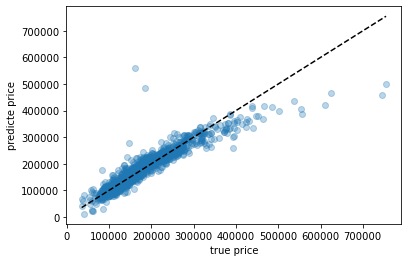

In [54]:
plt.scatter(y_train, lr_tuned.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, '--k');
plt.xlabel("true price");
plt.ylabel("predicte price");

- Here we can see a few cases where our prediction is way off.
- Is there something weird about those houses, perhaps? Outliers? 
- Under the line means we're under-prediction, over the line means we're over-predicting.

Question: Is an error of \$30,000 acceptable?

- For a house worth \$600k, it seems reasonable! That's 5% error.
- For a house worth \$60k, that is terrible. It's 50% error.

We have both of these cases in our dataset.

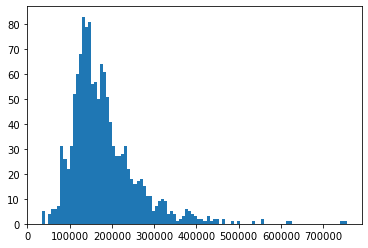

In [55]:
plt.hist(y_train, bins=100);

### MAPE

Can we compute percent error?

In [56]:
pred_train = lr_tuned.predict(X_train)
percent_errors = (pred_train - y_train)/y_train * 100.
percent_errors

302      5.547923
767     16.905006
429      8.030151
1139   -12.703746
558     16.034310
          ...    
1041     4.013123
1122   -29.569448
1346    -8.882241
1406     0.886021
1389     0.190094
Name: SalePrice, Length: 1314, dtype: float64

These are both positive (predict too high) and negative (predict too low).

We can look at the absolute percent error:

In [57]:
np.abs(percent_errors)

302      5.547923
767     16.905006
429      8.030151
1139    12.703746
558     16.034310
          ...    
1041     4.013123
1122    29.569448
1346     8.882241
1406     0.886021
1389     0.190094
Name: SalePrice, Length: 1314, dtype: float64

And, like MSE, we can take the average over examples. This is called mean absolute percent error (MAPE).

In [58]:
def mape(true, pred):
    return 100.*np.mean(np.abs((pred - true)/true))

In [59]:
mape(y_train, pred_train)

10.123589795169952

- Ok, this is quite interpretable.
- On average, we have around 10% error.

- In `sklearn` you will notice that it has negative version of the metrics above (e.g., `neg_mean_squared_error`, `neg_root_mean_squared_error`). 
- The reason for this is that scores return a value to maximize, the higher the better.
- If you define your own scorer function and if you do not want this interpretation, you can set the `greater_is_better` parameter to False 

### Different scoring functions with `cross_validate`

- Let's try using MSE instead of the default $R^2$ score. 

In [60]:
pd.DataFrame(cross_validate(
    lr_tuned, X_train, y_train, return_train_score=True, 
    scoring="neg_mean_squared_error"
))

,fit_time,score_time,test_score,train_score
0,0.042032,0.012104,-7.195290e+08,-9.263368e+08
1,0.038808,0.011029,-1.222522e+09,-8.262792e+08
2,0.037305,0.011858,-1.131822e+09,-8.651749e+08
3,0.038625,0.010884,-9.769864e+08,-8.776780e+08
4,0.037022,0.010537,-2.287955e+09,-7.316056e+08


In [61]:
def mape(true, pred):
    return 100.*np.mean(np.abs((pred - true)/true))

# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=True)

pd.DataFrame(cross_validate(
    lr_tuned, X_train, y_train, return_train_score=True, scoring=mape_scorer
))

,fit_time,score_time,test_score,train_score
0,0.041403,0.012583,9.782268,10.409307
1,0.039219,0.011714,10.846708,10.046602
2,0.035816,0.010942,11.920492,10.150553
3,0.040918,0.011732,10.882936,10.280463
4,0.038240,0.011591,12.169309,9.711958


In [62]:
scoring={
    "r2": "r2",
    "mape_scorer": mape_scorer,
    "neg_root_mean_square_error": "neg_root_mean_squared_error",    
    "neg_mean_squared_error": "neg_mean_squared_error",    
}

pd.DataFrame(cross_validate(
    lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring
)).T

,0,1,2,3,4
fit_time,4.486394e-02,4.084587e-02,3.606009e-02,3.852010e-02,3.663206e-02
score_time,1.389122e-02,1.190495e-02,1.159310e-02,1.169395e-02,1.179028e-02
test_r2,8.643530e-01,8.225613e-01,8.252302e-01,8.519350e-01,6.076025e-01
train_r2,8.569850e-01,8.637095e-01,8.597770e-01,8.573454e-01,8.846844e-01
test_mape_scorer,9.782268e+00,1.084671e+01,1.192049e+01,1.088294e+01,1.216931e+01
train_mape_scorer,1.040931e+01,1.004660e+01,1.015055e+01,1.028046e+01,9.711958e+00
test_neg_root_mean_square_error,-2.682404e+04,-3.496458e+04,-3.364257e+04,-3.125678e+04,-4.783257e+04
train_neg_root_mean_square_error,-3.043578e+04,-2.874507e+04,-2.941386e+04,-2.962563e+04,-2.704821e+04
test_neg_mean_squared_error,-7.195290e+08,-1.222522e+09,-1.131822e+09,-9.769864e+08,-2.287955e+09
train_neg_mean_squared_error,-9.263368e+08,-8.262792e+08,-8.651749e+08,-8.776780e+08,-7.316056e+08


In [63]:
mape(y_test, lr_tuned.predict(X_test))

9.591623407100776

## 5. Transforming the targets (optional)

- Does .fit() know we care about MAPE?
- No, it doesn't. Why are we minimizing MSE (or something similar) if we care about MAPE??
- When minimizing MSE, the expensive houses will dominate because they have the biggest error.
- Which is better for RMSE?

Model A

- Example 1: Truth: \$50k, Prediction: \\$100k
- Example 2: Truth: \$500k, Prediction: \\$550k
- RMSE: $50k
- MAPE: 45%


Model B

- Example 1: Truth: \$50k, Prediction: \\$60k
- Example 2: Truth: \$500k, Prediction: \\$600k
- RMSE: $71k
- MAPE: 20%

- How can we get `.fit()` to think about MAPE?
- Hacky approach that we'll take in this course: log transform the targets.
- That is, transform $y\rightarrow \log(y)$.
- Why? It tends to work in practice. 

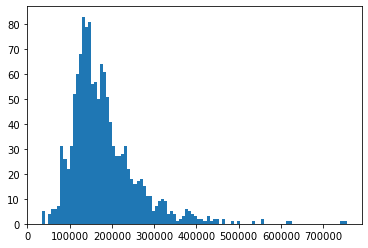

In [64]:
plt.hist(y_train, bins=100);

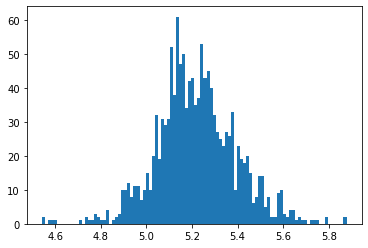

In [65]:
plt.hist(np.log10(y_train), bins=100);

We cam incorporate this in our pipeline using `sklearn`. 

In [66]:
from sklearn.compose import TransformedTargetRegressor

In [67]:
ttr = TransformedTargetRegressor(Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1)
ttr_pipe = make_pipeline(preprocessor, ttr)

In [68]:
ttr_pipe.fit(X_train, y_train); # y_train automatically transformed

In [69]:
ttr_pipe.predict(X_train) # predictions automatically un-transformed

array([224026.05358851, 176707.71798245, 181613.69708744, ...,
       245930.86429464, 132299.86111478, 131422.41519381])

In [70]:
mape(y_test, ttr_pipe.predict(X_test))

7.825292043880867

We reduced MAPE from ~10% to ~8% with this trick! 

### Summary

- House prices dataset target is price, which is numeric -> regression rather than classification
- There are corresponding versions of all the tools we used:
    - `DummyClassifier` -> `DummyRegressor`
    - `LogisticRegression` -> `Ridge`
- `Ridge` hyperparameter `alpha` is like `LogisticRegression` hyperparameter `C`, but opposite meaning
- We'll avoid `LinearRegression` in this course.

- Scoring metrics
- $R^2$ is the default .score(), it is unitless, 0 is bad, 1 is best
- MSE (mean squared error) is in units of target squared, hard to interpret; 0 is best
- RMSE (root mean squared error) is in the same units as the target; 0 is best
- MAPE (mean average percent error) is unitless; 0 is best, 1 is bad

## True/False questions for class discussion 


## For videos 1, 2, and 3 
1. Price per square foot would be a good feature to add in our `X`. 
2. `sklearn's` `LinearRegression` behaves erratically if we're not careful.
3. The `alpha` hyperparameter of `Ridge` has similar interpretation of `C` hyperparameter of `LogisticRegression`; higher `alpha` means more complex model. 
4. With `Ridge`, larger values of `alpha` are probably more useful when there are lots of features. (Not sure if we covered this enough for you to answer, but I'm leaving it here anyway.)


## For videos 4 and 5
1. In regression, one should use MAPE instead of MSE when relative (percent) error matters more than absolute error.